In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt

Init Plugin
Init Graph Optimizer
Init Kernel


# Linear Regression correction

The following code is the correction for the past notebook.
Please note that in this version we also track the loss over the batches using a fake `Mean`metrics.

In [2]:
def linear_regression_dataset():
    # --- Fake dataset ---

    np.random.seed(0)

    ntrain = 1000
    nvalid = 100
    ntest = 100

    # number of features
    nc = 4
    # number of outputs
    no = 2

    A = np.random.randn(nc, no)
    b = np.random.randn(no)

    print("True A\n", A)
    print("True b\n", b)

    def generate_one_dataset(A, b, n):
        nc, no = A.shape
        X = np.random.randn(n, nc)
        Y = X.dot(A)+b
        return np.array(X, dtype='float32'), np.array(Y, dtype='float32')

    Xtrain, Ytrain = generate_one_dataset(A, b, ntrain)
    Xvalid, Yvalid = generate_one_dataset(A, b, nvalid)
    Xtest, Ytest = generate_one_dataset(A, b, ntest)

    return (Xtrain, Ytrain), (Xvalid, Yvalid), (Xtest, Ytest)

class LinearRegression(tf.Module):
    def __init__(self, nc, no, name=None):
        super().__init__(name=name)
        # Linear regression parameters
        self.A = tf.Variable(tf.zeros([nc, no]))
        self.b = tf.Variable(tf.zeros([no]))

    @tf.function
    def __call__(self,x):
        return tf.matmul(x, self.A) + self.b

class LinearRegressionTrainer:
    
    def __init__(self):
        # !! NEW
        # fake metrics to follow the loss over the batches
        self._trainlossmetric = tf.metrics.Mean()
        self._trainmetric = tf.metrics.MeanAbsoluteError()
        self._validmetric = tf.metrics.MeanAbsoluteError()
        self._testmetric = tf.metrics.MeanAbsoluteError()
    
    # We will use the MSE loss
    def _loss(self,target,pred):
        return tf.reduce_mean(tf.math.squared_difference(target, pred))       

    @tf.function
    def _train_step(self,x,y):
        with tf.GradientTape() as tape:
            trainpred = self.module(x)
            trainloss = self._loss(y,trainpred)
        grads = tape.gradient(trainloss,self.module.trainable_variables)
        
        # !! NEW
        self._trainlossmetric.update_state(trainloss)
        
        self._trainmetric.update_state(y,trainpred)
        
        # Optimizer based on gradient descent
        # We let the optimizer do the gradient descent
        self.optimizer.apply_gradients(zip(grads, self.module.trainable_variables))
        
    @tf.function
    def _valid_step(self,x,y):
        validpred = self.module(x)
        validmetric = self._validmetric.update_state(y,validpred)

    @tf.function
    def _test_step(self,x,y):
        testpred = self.module(x)
        self._testmetric.update_state(y,testpred)

    @staticmethod
    def prepareset(dataset, batchsize):
        dataset = dataset.shuffle(buffer_size=1000)
        dataset = dataset.batch(batchsize)
        return dataset
    
    def train(self, trainset, validset, testset,
            learning_rate = 1e-2, training_epochs = 20,
            batchsize = 10):

        Xtrain, Ytrain = trainset
        Xvalid, Yvalid = validset
        Xtest, Ytest = testset

        # Xtrain (nxtrain,nc)
        nxtrain, self.nc = Xtrain.shape
        nxtest, _ = Xtest.shape
        # Ytrain (nxtrain,no)
        self.no = Ytrain.shape[1]
        
        traindataset = self.prepareset(tf.data.Dataset.from_tensor_slices(
            (Xtrain, Ytrain)), batchsize)
        validdataset = self.prepareset(tf.data.Dataset.from_tensor_slices(
            (Xvalid, Yvalid)), batchsize)
        testdataset = self.prepareset(
            tf.data.Dataset.from_tensor_slices((Xtest, Ytest)), batchsize)

        
        self.module = LinearRegression(self.nc,self.no)
        self.optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
        
        # We cycle on epochs
        for epoch in range(training_epochs):
            
            # !! NEW
            self._trainlossmetric.reset_state()
            
            self._trainmetric.reset_state()
            for Xtrain,Ytrain  in traindataset:
                self._train_step(Xtrain,Ytrain)

            self._validmetric.reset_state()
            for Xvalid,Yvalid  in validdataset:
                self._valid_step(Xvalid,Yvalid)
                
            print("Epoch %03d\t train loss %f\t train metric %f\t valid metric %f" %
                      (epoch, self._trainlossmetric.result(),
                       self._trainmetric.result(), self._validmetric.result()))
            
        self._testmetric.reset_state()
        for Xtest,Ytest  in testdataset:
            self._test_step(Xtest,Ytest)
        print("Test metric %f"%(self._testmetric.result(),))

        # Found parameters
        print("Estimated A\n", self.module.A.numpy())
        print('Estimated b\n', self.module.b.numpy())

trainer = LinearRegressionTrainer()
trainer.train(*linear_regression_dataset())

Metal device set to: Apple M1
True A
 [[ 1.76405235  0.40015721]
 [ 0.97873798  2.2408932 ]
 [ 1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721]]
True b
 [-0.10321885  0.4105985 ]


2021-09-10 17:17:23.519673: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-09-10 17:17:23.519763: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-09-10 17:17:23.629781: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-09-10 17:17:23.657405: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-10 17:17:23.658255: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-09-10 17:17:23.658355: I t

Epoch 000	 train loss 3.198577	 train metric 1.365553	 valid metric 0.842268
Epoch 001	 train loss 0.454033	 train metric 0.518134	 valid metric 0.318586
Epoch 002	 train loss 0.065419	 train metric 0.197345	 valid metric 0.121332
Epoch 003	 train loss 0.009557	 train metric 0.075099	 valid metric 0.046450
Epoch 004	 train loss 0.001415	 train metric 0.028865	 valid metric 0.017857
Epoch 005	 train loss 0.000212	 train metric 0.011073	 valid metric 0.006889
Epoch 006	 train loss 0.000032	 train metric 0.004282	 valid metric 0.002669
Epoch 007	 train loss 0.000005	 train metric 0.001659	 valid metric 0.001038
Epoch 008	 train loss 0.000001	 train metric 0.000650	 valid metric 0.000405
Epoch 009	 train loss 0.000000	 train metric 0.000255	 valid metric 0.000159
Epoch 010	 train loss 0.000000	 train metric 0.000101	 valid metric 0.000063
Epoch 011	 train loss 0.000000	 train metric 0.000039	 valid metric 0.000024
Epoch 012	 train loss 0.000000	 train metric 0.000016	 valid metric 0.000010

2021-09-10 17:17:26.120186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


# Logistic Regression

The following script generate a fake classification dataset.

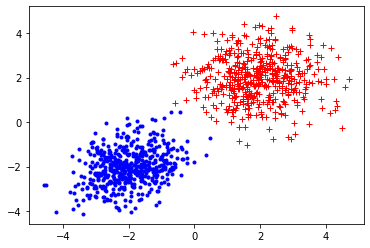

In [3]:
def logistic_regression_dataset():
    # --- Fake dataset ---

    np.random.seed(0)

    ntrain = 1000
    nvalid = 100
    ntest = 100

    mupos = np.array([2., 2.])
    sigmapos = np.array([[1., 0.], [0., 1.]])
    muneg = np.array([-2., -2.])
    sigmaneg = np.array([[.7, .2], [.2, .7]])

    def generate_a_dataset(mupos, sigmapos, muneg, sigmaneg, n):
        npos = int(n/2)
        nneg = n - npos

        Xpos = np.random.multivariate_normal(mupos, sigmapos, npos)
        Ypos = np.stack((np.ones((npos,)), np.zeros((npos,))), axis=1)

        Xneg = np.random.multivariate_normal(muneg, sigmaneg, nneg)
        Yneg = np.stack((np.zeros((nneg,)), np.ones((nneg,))), axis=1)

        X, Y = np.concatenate((Xpos, Xneg)), np.concatenate((Ypos, Yneg))

        idx = np.arange(n)
        np.random.shuffle(idx)
        X, Y = X[idx], Y[idx]

        return np.array(X, dtype='float32'), np.array(Y, dtype='float32')

    Xtrain, Ytrain = generate_a_dataset(
        mupos, sigmapos, muneg, sigmaneg, ntrain)
    Xvalid, Yvalid = generate_a_dataset(
        mupos, sigmapos, muneg, sigmaneg, nvalid)
    Xtest, Ytest = generate_a_dataset(mupos, sigmapos, muneg, sigmaneg, ntest)

    return (Xtrain, Ytrain), (Xvalid, Yvalid), (Xtest, Ytest)


def plot_dataset(X, Y):
    plt.figure()
    idpos, = np.nonzero(Y[:, 0] == 1.)
    idneg, = np.nonzero(Y[:, 1] == 1.)
    plt.plot(X[idpos, 0], X[idpos, 1], 'r+')
    plt.plot(X[idneg, 0], X[idneg, 1], 'b.')
    plt.show()


def demo(trainset, validset, testset):
    plot_dataset(*trainset)


demo(*logistic_regression_dataset())

## Exercise

Inspired by the precedent object oriented verision of the linear regression, write a logistic regression model:

$$\hat{y} = softmax(<x,A>+b)$$

It can be learnt by the cross-entropy loss:

$$ \mathcal{L}(y,\hat{y}) = -y\log\hat{y} - (1-y)\log(1-\hat{y})$$

In fact, that's a **one layer perceptron** !

You will have to use the following operations:
- `tf.matmul`
- `tf.nn.softmax`

You will have to use the following classes resplectively for the loss and metrics:
- `tf.losses.CategoricalCrossentropy`
- `tf.metrics.CategoricalAccuracy`

Please note that the `Categorical` loss and metrics need a two column prediction: one per class, as on-hot encoded, where all columns are 0 except 1 on the label column.
For exemple on a 3-class problem, 1 is encoded `[1 0 0]`, 2 is encoded `[0 1 0]` and 3 is encoded `[0 0 1]`.
Even if it is a binary problem, it is already  encoded that way in the current fake dataset.

Guidelines:

1) Copy the code of `LinearRegression` and `LinearRegressionTrainerV2` classes and rename them to `LogisticRegression` and `LogisticRegressionTrainer`, respectively.

2) Modify `__call__` of `LogisticRegression` method to have a logistic function with one output per class.

3) Modify `_loss` of `LogisticRegressionTrainer` to call a CategoricalCrossentropy instance.

```python
class LogisticRegressionTrainer():
    ...
    def __init__(...):
        self._trainloss = tf.losses.CategoricalCrossentropy()
        self._trainlossmetric = tf.metrics.Mean()
        ...
    ...
    def _loss(...):
        #should call self._trainloss(...) somewhere here

```

4) Modify the end of the `train` method of to print the result on test
```python
    class LogisticRegressionTrainer():
    ...
    def train(...):
        ...
        Xtest, Ytest = testset
        Ytestpred = self.module(Xtest)
        plt.figure()
        idpos, = np.nonzero(Ytestpred[:, 0] > 0.5)
        idneg, = np.nonzero(Ytestpred[:, 1] > 0.5)
        plt.plot(Xtest[idpos, 0], Xtest[idpos, 1], 'r+')
        plt.plot(Xtest[idneg, 0], Xtest[idneg, 1], 'b.')
        plt.show()

```



## Tensorboard

Tensorboard is an easy way to monitor the training of your model.
It is a dashboard in a web browser displaying metrics and possibly parameters of your model.

In order to do so you first need to export your metrics to log files.
Tensorboard will then explore the log files and show you the different graphs in your browser.


### Log writing

See the example code below.

```python

        # We create a new log writer
        logdir="logs/logisticregression/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
        summary_writer = tf.summary.create_file_writer(logdir)
        
        # We cycle on epochs
        for epoch in range(training_epochs):
            
            ...
            
            # We records into the log each scalar we want to track
            with summary_writer.as_default():
                tf.summary.scalar('trainloss', self._trainlossmetric.result(), step=epoch)
                tf.summary.scalar('trainacc', self._trainmetric.result(), step=epoch)
                tf.summary.scalar('validacc', self._validmetric.result(), step=epoch)
            
        ...

        # We may also record the test results into the log after the training
        with summary_writer.as_default():
            tf.summary.scalar('testacc', self._testmetric.result(), step=training_epochs)

```


### Log analyzing

A `logisticregressionlogs` folder will be create where the script is run.
It contains log file describing the evolution of the training.

To analyze them, we can actually launch tensorboard with the command inside a bash terminal:

```bash
tensorboard --logdir=logisticregressionlogs
```
It will automatically launch a web browser where you can monitor the metrics of your model.

**Caution !** as summaries and log files cumulate it is highly recommended to restart the python kernel and to erase the log folder before each execution of the script.

### Your turn !

Create a `LogisticRegressionTBTrainer` class derivated from `LogisticRegressionTrainer` and modify the train methods to log all the metrics.

